In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Clustering_using_K-Means").getOrCreate()
data_customer=spark.read.csv('CC GENERALL.csv', header=True, inferSchema=True)
data_customer.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



In [5]:
data_customer=data_customer.na.drop()

In [6]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=[
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE'], outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

In [7]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.2991816620055911
Silhouette Score: 0.27374782418403154
Silhouette Score: 0.3267167121758162
Silhouette Score: 0.3383570321082727
Silhouette Score: 0.3127273940792166
Silhouette Score: 0.28410303836970896
Silhouette Score: 0.3062367726865847
Silhouette Score: 0.29592663104122574


Text(0, 0.5, 'cost')

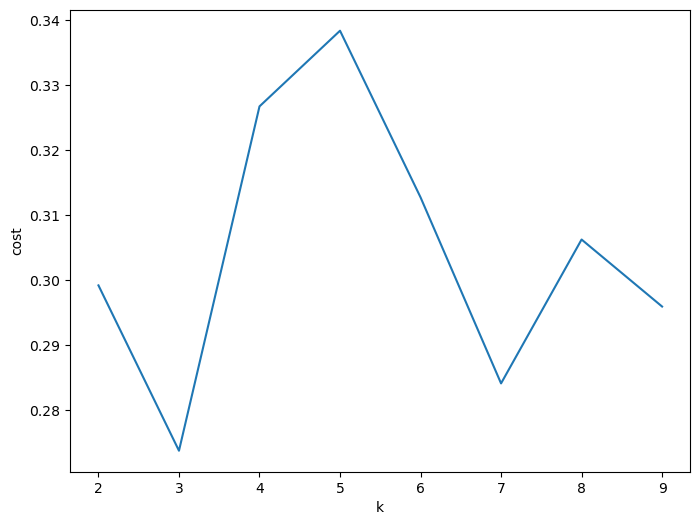

In [10]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")